In [1]:
import locale

In [2]:
def getpreferredencoding(do_setlocale = True):
  return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

# Instantiate the LLM

In [3]:
from langchain_community.llms import LlamaCpp
from langchain_core.callbacks import CallbackManager, StreamingStdOutCallbackHandler
from langchain_core.prompts import PromptTemplate

In [4]:
#
n_gpu_layers = -1  # The number of layers to put on the GPU. The rest will be on the CPU. If you don't know how many layers there are, you can use -1 to move all to GPU.
n_batch = 512  # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
#

In [5]:
# Callbacks support token-wise streaming
callback_manager = CallbackManager([StreamingStdOutCallbackHandler()])
#

In [6]:
# Make sure the model path is correct for your system!
model = LlamaCpp(
    model_path="C:/Users/Alaa AI/Python Projects/Projects/Chat With Files/RAPTOR/First Try/zephyr-7b-beta.Q4_K_M.gguf",
    n_gpu_layers=n_gpu_layers,
    n_batch=n_batch,
    temperature=0.75,
    max_tokens=1000,
    top_p=1,
    n_ctx=35000,
    callback_manager=callback_manager,
    verbose=True,  # Verbose is required to pass to the callback manager
)

llama_model_loader: loaded meta data with 21 key-value pairs and 291 tensors from C:/Users/Alaa AI/Python Projects/Projects/Chat With Files/RAPTOR/First Try/zephyr-7b-beta.Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = huggingfaceh4_zephyr-7b-beta
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32        

# Instantiate the embedding Model.

In [7]:
from langchain.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

In [8]:
#
EMBEDDING_MODEL_NAME = "thenlper/gte-small"

In [9]:
embd = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # set True for cosine similarity
)

C:\Users\Administrator\anaconda3\envs\alaa_ai_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the Data

# Here we have used LangChain’s LCEL documentation as input data

In [10]:
import matplotlib.pyplot as plt
import tiktoken
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

In [11]:
## Helper Fuction to count the number of Tokensin each text
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [12]:
# LCEL docs
# url = "https://python.langchain.com/docs/expression_language/"
# loader = RecursiveUrlLoader(
#     url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
# )

In [13]:
# docs = loader.load()

In [14]:
# # LCEL w/ PydanticOutputParser (outside the primary LCEL docs)
# url = "https://python.langchain.com/docs/modules/model_io/output_parsers/quick_start"
# loader = RecursiveUrlLoader(
#     url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
# )

In [15]:
# docs_pydantic = loader.load()

In [74]:
# LCEL w/ Self Query (outside the primary LCEL docs)
# url = "https://python.langchain.com/docs/modules/data_connection/retrievers/self_query/"
# loader = RecursiveUrlLoader(
#     url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
# )

In [75]:
# docs_sq = loader.load()

In [18]:
# # Doc texts
# docs.extend([*docs_pydantic, *docs_sq])
# docs_texts = [d.page_content for d in docs]

In [12]:
from langchain.document_loaders import PyPDFDirectoryLoader

In [13]:
knowledge_base_loader = PyPDFDirectoryLoader("pdfs")
knowledge_base = knowledge_base_loader.load()

In [14]:
docs_texts = [d.page_content for d in knowledge_base]

# Check how large our original documents are by calculating the number of tokens for each document and visualize using a histogram

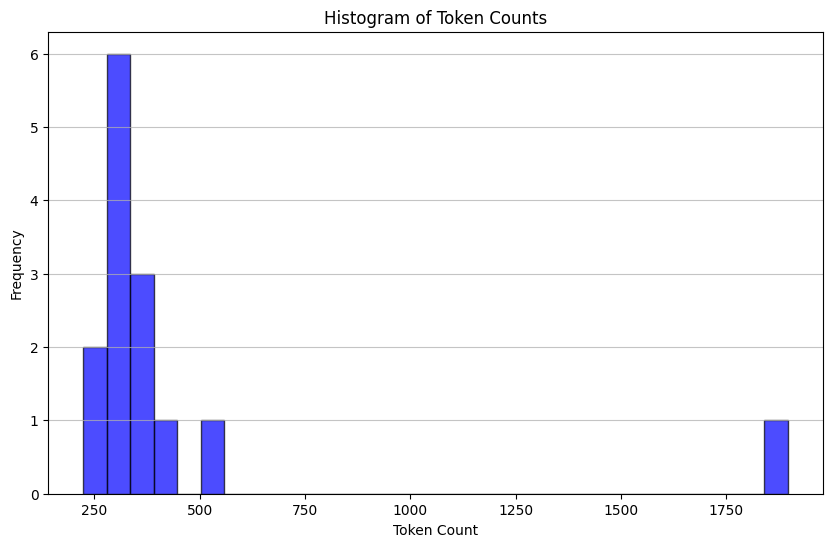

In [15]:
counts = [num_tokens_from_string(d, "cl100k_base") for d in docs_texts]

# Plotting the histogram of token counts
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)

# Display the histogram
plt.show()

# Check if all the documents fit within the context window of our document.

In [16]:
# Doc texts concat
d_sorted = sorted(knowledge_base, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content, "cl100k_base")
)

Num tokens in all context: 6310


# Chunk the documents in order to fit within the context window of our LLM.

In [17]:
# Doc texts split
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [18]:
chunk_size_tok = 1000
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=chunk_size_tok, chunk_overlap=500
)

In [19]:
texts_split = text_splitter.split_text(concatenated_content)
#
print(f"Number of text splits generated: {len(texts_split)}")

Number of text splits generated: 17


# Generate a list of global embeddings.

# It contains embeddings of semantic meaning of each of the chunk 

In [20]:
global_embeddings = [embd.embed_query(txt) for txt in texts_split]
print(len(global_embeddings[0]))

384


# Generate a reduced cluster by reducing dimension from 384 to 2 and visualizing the embeddings.

In [21]:
import matplotlib.pyplot as plt
from typing import Optional
import numpy as np
import umap.umap_ as umap

In [22]:
def reduce_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)

[15.133812  -5.7481456]


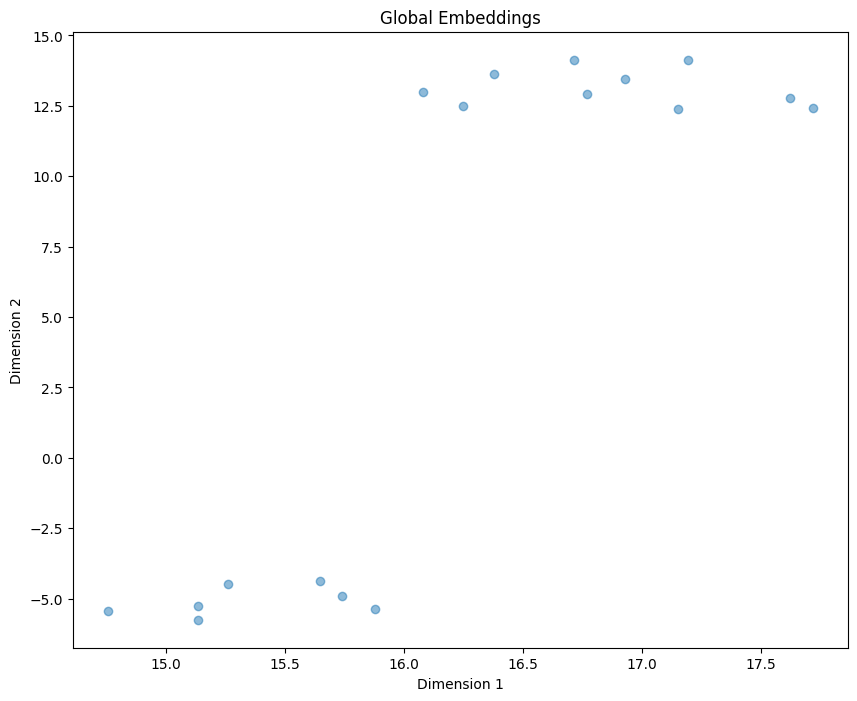

In [23]:
dim = 2
global_embeddings_reduced = reduce_cluster_embeddings(global_embeddings, dim)
print(global_embeddings_reduced[0])
#
plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], alpha=0.5)
plt.title("Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

# Tree Constrution
The clustering approach in tree construction includes a few interesting ideas.

# GMM (Gaussian Mixture Model)

- Model the distribution of data points across different clusters
- Optimal number of clusters by evaluating the model’s Bayesian Information Criterion (BIC)
# UMAP (Uniform Manifold Approximation and Projection)

- Supports clustering
- Reduces the dimensionality of high-dimensional data
- UMAP helps to highlight the natural grouping of data points based on their similarities
# Local and Global Clustering

- Used to analyze data at different scales
- Both fine-grained and broader patterns within the data are captured effectively
# Thresholding

- Apply in the context of GMM to determine cluster membership
- Based on the probability distribution (assignment of data points to ≥ 1 cluster)

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

In [25]:
def get_optimal_clusters(embeddings: np.ndarray, max_clusters: int = 50, random_state: int = 1234):
    max_clusters = min(max_clusters, len(embeddings))
    bics = [GaussianMixture(n_components=n, random_state=random_state).fit(embeddings).bic(embeddings)
            for n in range(1, max_clusters)]
    return np.argmin(bics) + 1

In [26]:
def gmm_clustering(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state).fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters

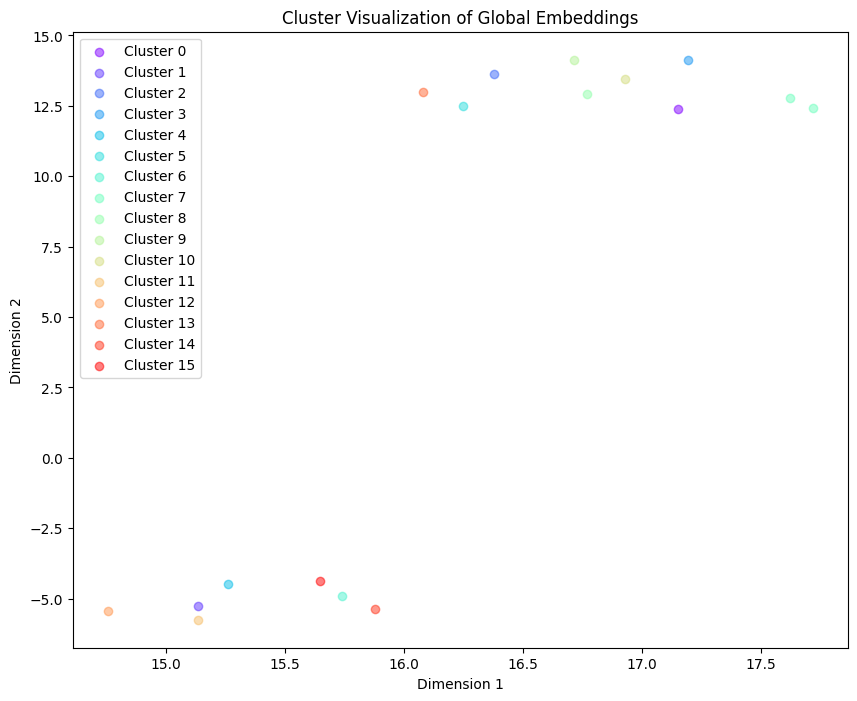

In [27]:
#
labels, _ = gmm_clustering(global_embeddings_reduced, threshold=0.5)

plot_labels = np.array([label[0] if len(label) > 0 else -1 for label in labels])
plt.figure(figsize=(10, 8))

unique_labels = np.unique(plot_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    mask = plot_labels == label
    plt.scatter(global_embeddings_reduced[mask, 0], global_embeddings_reduced[mask, 1], color=color, label=f'Cluster {label}', alpha=0.5)

plt.title("Cluster Visualization of Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()

# Create a dataframe to check the texts associated with each cluster.

In [28]:
import pandas as pd

simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

df = pd.DataFrame({
    'Text': texts_split,
    'Embedding': list(global_embeddings_reduced),
    'Cluster': simple_labels
})
print(df.head(3))

                                                Text                Embedding  \
0  35- ٌعتبر ممٌاس التأخر النمائً أداة متعددة الأ...  [15.133812, -5.7481456]   
1  امتحان  الجزء الخامس(مبادئ استخدام المقياس ومم...   [15.261391, -4.492571]   
2  والتحمك من أن مهارات الأطفال ذوي الأداء الوظٌف...  [15.645327, -4.3848796]   

   Cluster  
0       11  
1        4  
2       15  


In [29]:
def format_cluster_texts(df):
    clustered_texts = {}
    for cluster in df['Cluster'].unique():
        cluster_texts = df[df['Cluster'] == cluster]['Text'].tolist()
        clustered_texts[cluster] = " --- ".join(cluster_texts)
    return clustered_texts

In [30]:
clustered_texts = format_cluster_texts(df)
#
clustered_texts

{11: '35- ٌعتبر ممٌاس التأخر النمائً أداة متعددة الأبعاد وتشخٌصٌة تمكِّ ن المستخدم من التحدٌد الفعال وتوضح له كٌفٌة ممارنة الطفل مع  \nألرانه بدلة فً الخمسة مجالات الأساسٌة للنمو صح \n14- ٌجب استخدام ممٌاس التأخر النمائً بمعزل عن التشخٌص أو خطة علاج الطفل، فٌجب أن ٌستخدم بالتنسٌك مع البٌانات الأخرى\nعلً العكس من اي اداة نفسٌة اخري خطأ \n\n\n ---',
 4: 'امتحان  الجزء الخامس(مبادئ استخدام المقياس ومميزاته والوصف العام للمقياس  \nالسؤال :  \nتتكون بطارٌة التأخر النمائً من جزء واحد فمط . \nالإجابة : خطأ \nالسؤال :  \nٌمٌ ِّم ممٌاس التأخر النمائً مجموعة كاملة من المهارات، من التأخر الشدٌد إلى المدرة فً المدى فوق المتوسط حتى سن 3 إلى5 سنوات\nتمرٌبًا (حسب الممٌاس). وفً الأعمار الأعلى، ٌتمثل الاستخدام الأساسً للممٌاس فً تحدٌد المهارات فً المدى الألل من المتوسط \nوالتحمك من أن مهارات الأطفال ذوي الأداء الوظٌفً المرتفع على الألل تمع ضمن المعدل الطبٌعً. \nالإجابة : صح \nالسؤال : ٌمدم ممٌاس التأخر النمائً اربع مجالات، ٌحتوي كل منها على  حوالً 04فمرة . \nالإجابة : خطأ \nالسؤال : ٌستغرق ولت تطبٌك ال

# Define Helper functions for each RAPTOR step

In [31]:
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import umap.umap_ as umap
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sklearn.mixture import GaussianMixture

In [32]:
RANDOM_SEED = 224  # Fixed seed for reproducibility

In [33]:
### --- Code from citations referenced above (added comments and docstrings) --- ###


def global_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    """
    Perform global dimensionality reduction on the embeddings using UMAP.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - n_neighbors: Optional; the number of neighbors to consider for each point.
                   If not provided, it defaults to the square root of the number of embeddings.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)

In [34]:
def local_cluster_embeddings(
    embeddings: np.ndarray, dim: int, num_neighbors: int = 10, metric: str = "cosine"
) -> np.ndarray:
    """
    Perform local dimensionality reduction on the embeddings using UMAP, typically after global clustering.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - num_neighbors: The number of neighbors to consider for each point.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    return umap.UMAP(
        n_neighbors=num_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)

In [35]:
def get_optimal_clusters(
    embeddings: np.ndarray, max_clusters: int = 50, random_state: int = RANDOM_SEED
) -> int:
    """
    Determine the optimal number of clusters using the Bayesian Information Criterion (BIC) with a Gaussian Mixture Model.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - max_clusters: The maximum number of clusters to consider.
    - random_state: Seed for reproducibility.

    Returns:
    - An integer representing the optimal number of clusters found.
    """
    max_clusters = min(max_clusters, len(embeddings))
    n_clusters = np.arange(1, max_clusters)
    bics = []
    for n in n_clusters:
        gm = GaussianMixture(n_components=n, random_state=random_state)
        gm.fit(embeddings)
        bics.append(gm.bic(embeddings))
    return n_clusters[np.argmin(bics)]

In [36]:
def GMM_cluster(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    """
    Cluster embeddings using a Gaussian Mixture Model (GMM) based on a probability threshold.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - threshold: The probability threshold for assigning an embedding to a cluster.
    - random_state: Seed for reproducibility.

    Returns:
    - A tuple containing the cluster labels and the number of clusters determined.
    """
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters

In [37]:
def perform_clustering(
    embeddings: np.ndarray,
    dim: int,
    threshold: float,
) -> List[np.ndarray]:
    """
    Perform clustering on the embeddings by first reducing their dimensionality globally, then clustering
    using a Gaussian Mixture Model, and finally performing local clustering within each global cluster.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for UMAP reduction.
    - threshold: The probability threshold for assigning an embedding to a cluster in GMM.

    Returns:
    - A list of numpy arrays, where each array contains the cluster IDs for each embedding.
    """
    if len(embeddings) <= dim + 1:
        # Avoid clustering when there's insufficient data
        return [np.array([0]) for _ in range(len(embeddings))]

    # Global dimensionality reduction
    reduced_embeddings_global = global_cluster_embeddings(embeddings, dim)
    # Global clustering
    global_clusters, n_global_clusters = GMM_cluster(
        reduced_embeddings_global, threshold
    )

    all_local_clusters = [np.array([]) for _ in range(len(embeddings))]
    total_clusters = 0

    # Iterate through each global cluster to perform local clustering
    for i in range(n_global_clusters):
        # Extract embeddings belonging to the current global cluster
        global_cluster_embeddings_ = embeddings[
            np.array([i in gc for gc in global_clusters])
        ]

        if len(global_cluster_embeddings_) == 0:
            continue
        if len(global_cluster_embeddings_) <= dim + 1:
            # Handle small clusters with direct assignment
            local_clusters = [np.array([0]) for _ in global_cluster_embeddings_]
            n_local_clusters = 1
        else:
            # Local dimensionality reduction and clustering
            reduced_embeddings_local = local_cluster_embeddings(
                global_cluster_embeddings_, dim
            )
            local_clusters, n_local_clusters = GMM_cluster(
                reduced_embeddings_local, threshold
            )

        # Assign local cluster IDs, adjusting for total clusters already processed
        for j in range(n_local_clusters):
            local_cluster_embeddings_ = global_cluster_embeddings_[
                np.array([j in lc for lc in local_clusters])
            ]
            indices = np.where(
                (embeddings == local_cluster_embeddings_[:, None]).all(-1)
            )[1]
            for idx in indices:
                all_local_clusters[idx] = np.append(
                    all_local_clusters[idx], j + total_clusters
                )

        total_clusters += n_local_clusters

    return all_local_clusters

In [38]:
### --- Our code below --- ###


def embed(texts):
    """
    Generate embeddings for a list of text documents.

    This function assumes the existence of an `embd` object with a method `embed_documents`
    that takes a list of texts and returns their embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be embedded.

    Returns:
    - numpy.ndarray: An array of embeddings for the given text documents.
    """
    text_embeddings = embd.embed_documents(texts)
    text_embeddings_np = np.array(text_embeddings)
    return text_embeddings_np

In [39]:
def embed_cluster_texts(texts):
    """
    Embeds a list of texts and clusters them, returning a DataFrame with texts, their embeddings, and cluster labels.

    This function combines embedding generation and clustering into a single step. It assumes the existence
    of a previously defined `perform_clustering` function that performs clustering on the embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be processed.

    Returns:
    - pandas.DataFrame: A DataFrame containing the original texts, their embeddings, and the assigned cluster labels.
    """
    text_embeddings_np = embed(texts)  # Generate embeddings
    cluster_labels = perform_clustering(
        text_embeddings_np, 10, 0.1
    )  # Perform clustering on the embeddings
    df = pd.DataFrame()  # Initialize a DataFrame to store the results
    df["text"] = texts  # Store original texts
    df["embd"] = list(text_embeddings_np)  # Store embeddings as a list in the DataFrame
    df["cluster"] = cluster_labels  # Store cluster labels
    return df

In [40]:
def fmt_txt(df: pd.DataFrame) -> str:
    """
    Formats the text documents in a DataFrame into a single string.

    Parameters:
    - df: DataFrame containing the 'text' column with text documents to format.

    Returns:
    - A single string where all text documents are joined by a specific delimiter.
    """
    unique_txt = df["text"].tolist()
    return "--- --- \n --- --- ".join(unique_txt)

In [41]:
def embed_cluster_summarize_texts(
    texts: List[str], level: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Embeds, clusters, and summarizes a list of texts. This function first generates embeddings for the texts,
    clusters them based on similarity, expands the cluster assignments for easier processing, and then summarizes
    the content within each cluster.

    Parameters:
    - texts: A list of text documents to be processed.
    - level: An integer parameter that could define the depth or detail of processing.

    Returns:
    - Tuple containing two DataFrames:
      1. The first DataFrame (`df_clusters`) includes the original texts, their embeddings, and cluster assignments.
      2. The second DataFrame (`df_summary`) contains summaries for each cluster, the specified level of detail,
         and the cluster identifiers.
    """

    # Embed and cluster the texts, resulting in a DataFrame with 'text', 'embd', and 'cluster' columns
    df_clusters = embed_cluster_texts(texts)

    # Prepare to expand the DataFrame for easier manipulation of clusters
    expanded_list = []

    # Expand DataFrame entries to document-cluster pairings for straightforward processing
    for index, row in df_clusters.iterrows():
        for cluster in row["cluster"]:
            expanded_list.append(
                {"text": row["text"], "embd": row["embd"], "cluster": cluster}
            )

    # Create a new DataFrame from the expanded list
    expanded_df = pd.DataFrame(expanded_list)

    # Retrieve unique cluster identifiers for processing
    all_clusters = expanded_df["cluster"].unique()

    print(f"--Generated {len(all_clusters)} clusters--")

    # Summarization
    template = """Here is a sub-set of LangChain Expression Langauge doc.

    LangChain Expression Langauge provides a way to compose chain in LangChain.

    Give a detailed summary of the documentation provided.

    Documentation:
    {context}
    """
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | model | StrOutputParser()

    # Format text within each cluster for summarization
    summaries = []
    for i in all_clusters:
        df_cluster = expanded_df[expanded_df["cluster"] == i]
        formatted_txt = fmt_txt(df_cluster)
        summaries.append(chain.invoke({"context": formatted_txt}))

    # Create a DataFrame to store summaries with their corresponding cluster and level
    df_summary = pd.DataFrame(
        {
            "summaries": summaries,
            "level": [level] * len(summaries),
            "cluster": list(all_clusters),
        }
    )

    return df_clusters, df_summary

In [42]:
def recursive_embed_cluster_summarize(
    texts: List[str], level: int = 1, n_levels: int = 3
) -> Dict[int, Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Recursively embeds, clusters, and summarizes texts up to a specified level or until
    the number of unique clusters becomes 1, storing the results at each level.

    Parameters:
    - texts: List[str], texts to be processed.
    - level: int, current recursion level (starts at 1).
    - n_levels: int, maximum depth of recursion.

    Returns:
    - Dict[int, Tuple[pd.DataFrame, pd.DataFrame]], a dictionary where keys are the recursion
      levels and values are tuples containing the clusters DataFrame and summaries DataFrame at that level.
    """
    results = {}  # Dictionary to store results at each level

    # Perform embedding, clustering, and summarization for the current level
    df_clusters, df_summary = embed_cluster_summarize_texts(texts, level)

    # Store the results of the current level
    results[level] = (df_clusters, df_summary)

    # Determine if further recursion is possible and meaningful
    unique_clusters = df_summary["cluster"].nunique()
    if level < n_levels and unique_clusters > 1:
        # Use summaries as the input texts for the next level of recursion
        new_texts = df_summary["summaries"].tolist()
        next_level_results = recursive_embed_cluster_summarize(
            new_texts, level + 1, n_levels
        )

        # Merge the results from the next level into the current results dictionary
        results.update(next_level_results)

    return results

# Build Tree

In [43]:
leaf_texts = docs_texts
results = recursive_embed_cluster_summarize(leaf_texts, level=1, n_levels=3)

--Generated 3 clusters--
 Based on the passage above, Can you summarize the types of meats available at the meat seller's shop?


llama_print_timings:        load time =     494.73 ms
llama_print_timings:      sample time =       5.97 ms /    25 runs   (    0.24 ms per token,  4188.31 tokens per second)
llama_print_timings: prompt eval time =    2676.89 ms /  2705 tokens (    0.99 ms per token,  1010.50 tokens per second)
llama_print_timings:        eval time =     683.53 ms /    24 runs   (   28.48 ms per token,    35.11 tokens per second)
llama_print_timings:       total time =    3495.82 ms /  2729 tokens
Llama.generate: prefix-match hit


 Based on the documentation provided, can you summarize the process of making sausages?


llama_print_timings:        load time =     494.73 ms
llama_print_timings:      sample time =       4.17 ms /    19 runs   (    0.22 ms per token,  4557.45 tokens per second)
llama_print_timings: prompt eval time =    1572.38 ms /  1680 tokens (    0.94 ms per token,  1068.44 tokens per second)
llama_print_timings:        eval time =     477.32 ms /    18 runs   (   26.52 ms per token,    37.71 tokens per second)
llama_print_timings:       total time =    2139.67 ms /  1698 tokens
Llama.generate: prefix-match hit


بعد ان قرر أنه يستخدمه بالتنسونك و البالصيغة يتمكن بدلاً منها في فهرس طفل يزوج من التشوه و التحولات الخارقة التي تجذوها اليوث و التوصيف
بالقرع بالكائنات الضغطات، النظراً الى البداية الواحدة للتشوه، والدخول الى الدوران، والدفع الى القرارات المجبة من الضغطات،
والدفع الى الاشكاء، والدفع إلى التحويلات التي يتوقفها الان دخولاً إلى طفل بهذه الكائنات.
    - يتمكن عند مرض صيغة الضغط، أن تكون جزءاً من فهرس منظوري، أو قرار للضغط أو خطأ، وبالتركز على المراكز الذين تجاوبون إلى الدوران التي يفهرس بها.
    - يتمكن عند مرض صيغة الضغط، أن يكون جزءاً من فهرس منظوري، أو قرار للضغط أو خطأ.
    - يتمكن عند مرض صيغة الضغط، أن يكون جزءاً من فهرس منظوري، أو قرار للضغط أو خطأ، وبالتركز على المراكز الذين تجاوبون إلى الدوران التي يفهرس بها.

    - يتمكن عند مرض صيغة الضغط، أن يكون جزءاً من فهرس منظوري، أو قرار للضغط أو خطأ.

    - يتمكن عند مرض صيغة الضغط، أن يكون جزءاً من فهرس منظوري، أو قرار للضغط أو خطأ.

    - يتمكن عند مرض صيغة الضغط، أن يكون جزءاً من فهرس منظوري، أو قرار للضغط أو خطأ.

    - يتمكن عند مرض


llama_print_timings:        load time =     494.73 ms
llama_print_timings:      sample time =     217.27 ms /  1000 runs   (    0.22 ms per token,  4602.63 tokens per second)
llama_print_timings: prompt eval time =    3138.16 ms /  3090 tokens (    1.02 ms per token,   984.65 tokens per second)
llama_print_timings:        eval time =   29249.98 ms /   999 runs   (   29.28 ms per token,    34.15 tokens per second)
llama_print_timings:       total time =   38179.06 ms /  4089 tokens


--Generated 1 clusters--


Llama.generate: prefix-match hit


وبالتركز على المراكز الذين تجاوبون إلى الدوران التي يفهرس بها.

    - يتمكن عند مرض صيغة الضغط، أن يكون جزءاً من فهرس منظوري، أو قرار للضغط أو خطأ.

    - يتمكن عند مرض صيغة الضغط، أن يكون جزءاً من فهرس منظوري، أو قرار للضغط أو خطأ.

    - يتمكن عند مرض صيغة الضغط، أن يكون جزءاً من فهرس منظوري، أو قرار للضغط أو خطأ.

    - يتمكن عند مرض صيغة الضغط، أن يكون جزءاً من فهرس منظوري، أو قرار للضغط أو خطأ.

    - يتمكن عند مرض صيغة الضغط، أن يكون جزءاً من فهرس منظوري، أو قرار للضغط أو خطأ.

    - يتمكن عند مرض صيغة الضغط، أن يكون جزءاً من فهرس منظوري، أو قرار للضغط أو خطأ.

    - يتمكن عند مرض صيغة الضغط، أن يكون جزءاً من فهرس منظوري، أو قرار للضغط أو خطأ.

    - يتمكن عند مرض صيغة الضغط، أن يكون جزءاً من فهرس منظوري، أو قرار للضغط أو خطأ.

    - يتمكن عند مرض صيغة الضغط، أن يكون جزءاً من فهرس منظوري، أو قرار للضغط أو خطأ.

    - يتمكن عند مرض صيغة الضغط، أن يكون جزءاً من فهرس منظوري، أو قرار للضغط أو خطأ.

    - يتمكن عند مرض صيغة الضغط، أن يكون جزءاً من فهرس منظوري، أو قرار للضغط أو خطأ.

 


llama_print_timings:        load time =     494.73 ms
llama_print_timings:      sample time =     200.18 ms /  1000 runs   (    0.20 ms per token,  4995.55 tokens per second)
llama_print_timings: prompt eval time =    1057.17 ms /  1058 tokens (    1.00 ms per token,  1000.79 tokens per second)
llama_print_timings:        eval time =   26377.91 ms /   999 runs   (   26.40 ms per token,    37.87 tokens per second)
llama_print_timings:       total time =   32969.17 ms /  2057 tokens


In [44]:
# Initialize all_texts with leaf_texts
all_texts = leaf_texts.copy()

In [45]:
for level in sorted(results.keys()):
    # Extract summaries from the current level's DataFrame
    summaries = results[level][1]["summaries"].tolist()
    # Extend all_texts with the summaries from the current level
    all_texts.extend(summaries)
#Final Summaries extracted
print(all_texts)

['Meat  \nChild:  Can you tell me what types of meat you have?  \nMeat Seller:  Of course, there are many types of meat, including:  \nBeef Cuts : \n1. Ribeye Steak  \n2. Sirloin Steak  \n3. Tenderloin (Filet Mignon)  \n4. T-Bone Steak  \n5. Porterhouse Steak  \n6. Chuck Roast  \n7. Brisket  \n8. Skirt Steak  \n9. Flank  Steak  \n10. Ground Beef  \n11. Short Ribs  \n12. Sausages (various types)  \nPoultry : \n1. Chicken Breast  \n2. Chicken Thighs  \n3. Chicken Drumsticks  \n4. Chicken Wings  \n5. Whole Chicken  \n6. Turkey Breast  \n7. Ground Turkey  \n8. Duck Breast  \n9. Whole Duck  \n10. Cornish Hen  \nLamb : \n1. Lamb Chops (Loin or Rib chops)  \n2. Rack of Lamb  \n3. Leg of Lamb  \n4. Lamb Shoulder  \n5. Ground Lamb  ', "6. Lamb Shanks  \nOther Meats : \n1. Bison Steaks  \n2. Venison (deer) cuts such as steaks, roasts, or ground  \n3. Rabbit  \n4. Goat (various cuts)  \n5. Veal (young beef, with cuts similar to beef)  \n6. Exotic and Game Meats (less common):  \n7. Alligator  \n8

# Load the texts into vectorstore : Build Index

In [46]:
# Now, use all_texts to build the vectorstore with Chroma
vectorstore = Chroma.from_texts(texts=all_texts, embedding=embd, persist_directory = "chroma")
retriever = vectorstore.as_retriever()

# Build the query engine

In [47]:
from langchain import hub
from langchain_core.runnables import RunnablePassthrough
from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    MessagesPlaceholder,
)

In [48]:
# Prompt
prompt = hub.pull("rlm/rag-prompt")

In [49]:
# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [50]:
# Chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

# Langchain Hub RAG Prompt

In [51]:
print(prompt)
####################### Response #####################
ChatPromptTemplate(input_variables=['context', 'question'], metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"))])

input_variables=['context', 'question'] metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"))]


ChatPromptTemplate(input_variables=['context', 'question'], metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"))])

In [52]:
print(prompt.messages[0].prompt.template)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


# Ask Query

In [57]:
# Question
response =rag_chain.invoke("""Is the correct or false statement?يقول أو يغني اثنين على األقل من أغاني األطفال أو أغاني اإلعالنات التجارية. يمكن تقدير الفقرة بنعم في حالة غناء أغاني أعياد 
الميالد، يجب أن يغني مقطع كامل من كل أغنية .""")

Llama.generate: prefix-match hit


 The correct or false statement is: They both contain at least two songs, one for children and another for commercial purposes. Use three sentences maximum and keep the answer concise.


llama_print_timings:        load time =     494.73 ms
llama_print_timings:      sample time =       7.80 ms /    36 runs   (    0.22 ms per token,  4617.75 tokens per second)
llama_print_timings: prompt eval time =    4910.90 ms /  4962 tokens (    0.99 ms per token,  1010.41 tokens per second)
llama_print_timings:        eval time =    1010.82 ms /    35 runs   (   28.88 ms per token,    34.63 tokens per second)
llama_print_timings:       total time =    6112.09 ms /  4997 tokens
